In [83]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers


import sys
from collections import Counter 
import pprint 
import math
import argparse 
import os
import collections
import json
import re
import numpy as np
import matplotlib.pyplot as plt 
import random
import time 
import pandas as pd

In [2]:
def parse_json(filepath):
    """
    function used to parse json of each commit json file

    Args:
        filepath_list - list of filepaths

    Returns:
        files_json - list object contains parsed information

    """

    files_json = []
    commit_ids = []

    # each commits
    files = os.listdir(filepath)
    for path in files:
        commit_id = path.split('_')[1].split('.')[0]
        if os.stat(filepath + path).st_size != 0 and path != 'desktop.ini':
            with open(filepath + path, encoding="utf8") as f:
                data = json.load(f)
                files_list = []
                # each file in commits
                for file in data['files']:
                    # parse only cluster file
                    for key in file.keys():
                        if re.match('^.*_cluster$', key):
                            actions_list = []
                            actions = file[key]['actions']
                            # each action in file
                            for action in actions:
                                actions_list.append(action['root'])
                            files_list.append(actions_list)
            if len(files_list) != 0:
                files_json.append(files_list)
                commit_ids.append(commit_id)
    assert len(commit_ids) == len(files_json)
    # return
    return files_json, commit_ids


folder_path = './tmp_JSON_labeled_commits/'
all_files, commit_ids = parse_json(folder_path)

In [3]:
def preprocess_roots(files_data):
    counting = {}
    for file_index, files in enumerate(files_data):
        for root_index, roots in enumerate(files):
            for action_index, actions in enumerate(roots):
                temp = actions.split(' at ')[0].strip()
                tempq = []
                if temp.startswith('INS'):
                    tempq.append('INS')
                    words = [temp.split('INS ')[1].split('to ')[0].strip()
                             ] + [temp.split('INS ')[1].split('to ')[-1].strip()]
                    for items in words:

                        items = items.split(': ')[0].strip()
                        tempq.append(items)
                    temp = '_'.join(tempq)

                if temp.startswith('UPDATE'):
                    temp = 'UPDATE'
                if temp.startswith('MOVE'):
                    temp2 = temp.split(' from ')[1].strip()
                    tempq.append('MOVE')
                    tempq.append(temp2.split(': ')[0].strip())
                    temp = '_'.join(tempq)

                if temp.startswith('DEL'):
                    tempq.append('DEL')
                    tempq.append(temp.split('DEL ')[1].split(': ')[0].strip())
                    temp = '_'.join(tempq)
                counting[temp] = counting.get(temp, 0) + 1
                files_data[file_index][root_index][action_index] = temp
    dic = {}
    i = 0
    for k, v in counting.items():
        dic[k] = i  
        i += 1
    return dic, files_data, counting

In [4]:
dic, datas, freq_dict = preprocess_roots(all_files)
rev_dic = dict(zip(dic.values(), dic.keys()))

In [5]:
def actions2sentence(datas):
    data_total = []
    for files in datas:
        data4file = []
        for roots in files:
            sentence = ' '.join(roots)
            data4file.append(sentence)
        data_total.append(data4file)
    return data_total


training_data = actions2sentence(datas)

In [6]:
def concat_files_to_sentence(training_data): 
    concat_data = ""
    tmp_list = []
    for items in training_data:
        concat_data = " ".join(items)
        tmp_list.append(concat_data)
        
    return tmp_list

concat_train_data = concat_files_to_sentence(training_data)

<sample training data>:  ['INS_ImportDeclaration_CompilationUnit INS_FieldDeclaration_TypeDeclaration INS_FieldDeclaration_TypeDeclaration UPDATE MOVE_VariableDeclarationFragment INS_ExpressionStatement_Block INS_ExpressionStatement_Block UPDATE UPDATE INS_SimpleName_MethodInvocation INS_SimpleName_MethodInvocation INS_SimpleName_MethodInvocation INS_ClassInstanceCreation_MethodInvocation DEL_SimpleName DEL_ExpressionStatement DEL_SimpleName', 'INS_ImportDeclaration_CompilationUnit INS_VariableDeclarationStatement_Block INS_IfStatement_Block', 'INS_ImportDeclaration_CompilationUnit INS_FieldDeclaration_TypeDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_ExpressionStatement_Block INS_ExpressionStatement_Block INS_ExpressionStatement_Block INS_ExpressionStatement_Block INS_ExpressionStatement_Block INS_ExpressionStatement_Block UPDATE INS_ExpressionStatement_Block INS_IfStatement_Block INS_ExpressionStatement_Block INS_Expre

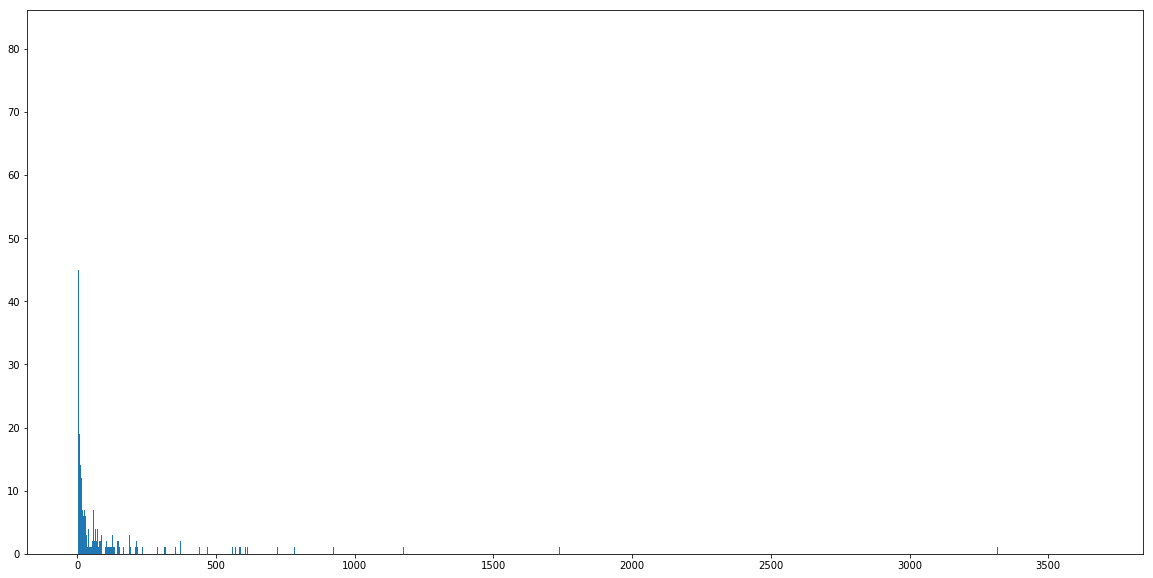

In [7]:
def get_seqlength(training_data):
    max_root_len = 0
    seqlength_list = []
    for item in training_data:
        seqlength_list.append(len(item.split()))
        if len(item.split()) >  max_root_len: 
            max_root_len = len(item.split())
    return max_root_len, seqlength_list

def plot_hist(seqlength_list): 
    plt.figure(figsize=(20,10))
    number_of_files = np.array(seqlength_list)
    bincount = np.bincount(seqlength_list)
    x = np.arange(1, len(bincount)+1)
    n, bins, patches = plt.hist(seqlength_list,x)

max_seqlength, sequence_list = get_seqlength(concat_train_data)
print("<sample training data>: ", training_data[0])
plot_hist(sequence_list)

In [8]:
# getting file threshold
threshold = 0.95
number_of_actions = [len(item.split()) for item in concat_train_data]

def get_file_threshold(number_of_files, threshold = 0.95):
    '''
    get padding threshold for files dimension
    
    Args:
        number_of_files - array of the number of files in each commits
        threshold - drop all commits with its the number of files beyond this threshold
    Returns:
        padding threshold - number
    '''
    
    total_files = len(number_of_files)
    number_of_files = np.array(number_of_files)
    bincount = np.bincount(number_of_files)

    sum_file = 0
    for index, item in enumerate(bincount):
        sum_file += item
        #print(index,item)
        #print(sum_file)
        if sum_file > threshold*total_files:
            padding_files_threshold = index
            break
            
    return padding_files_threshold

length_threshold = get_file_threshold(number_of_actions, threshold)
print(length_threshold)

275


In [9]:
df = pd.DataFrame(data = [ commit_ids, concat_train_data]).T
df.columns = ['csha','sequence']
df.head()

,csha,sequence
0,3dd2210e79a8eb84378c370b32652f9a53f87a93,INS_ImportDeclaration_CompilationUnit INS_Fiel...
1,e691b66aadbed87ac4891cec2ca5136bc85cfe4d,INS_VariableDeclarationStatement_Block INS_Try...
2,1f959d076ed7f29c3f8a5c6e99cbfcc62c1058d9,INS_ImportDeclaration_CompilationUnit INS_Impo...
3,1a7286afce71c005bae8d45e6b280e977f823a79,INS_ImportDeclaration_CompilationUnit INS_Impo...
4,4c0a65457cb7a16578592cfb2278a2bb99f78cad,MOVE_SingleVariableDeclaration DEL_TypeParamet...


In [10]:
df['len_seq'] = df.apply(lambda row: len(row['sequence'].split()), axis = 1)
df = df[df['len_seq'] <= length_threshold].reset_index(drop = True)
print(df.shape)

(774, 3)


In [11]:
from utils.handle_labels import get_tag_counts_and_labels
from utils.handle_labels import drop_labels
from utils.handle_labels import group_labels
from utils.handle_labels import categories_count
from utils.handle_labels import get_imbalance
from utils.handle_labels import label_distribution
from utils.handle_labels import number_of_labels
from utils.message_preprocess import message_processing
# plot untils funcion
from utils.plot_utils import pie_plot

[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/apple/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
df_new = pd.read_csv('data/commit_data_new.csv')
print(df_new.shape)

# convert string to list
from ast import literal_eval

df_new['categories'] = df_new['categories'].apply(lambda x: literal_eval(x))
print(type(df_new['categories'].values[0]))
print(df_new['categories'].values[0])
df_new = df_new.drop(['Unnamed: 0'], axis = 1)
df_new = drop_labels(df_new, ['Testing', 'Build'])

(1922, 28)
<class 'list'>
['Testing', 'Bug fix']


In [13]:
df.columns = ['Commit ID','sequence', 'len_seq']
result = pd.merge(df, df_new, on='Commit ID')
result.head()

,Commit ID,sequence,len_seq,project name,commit_message,Maintenance,Feature Add,Bug fix,Documentation,Clean up,...,Module Remove,Module Move,Rename,Versioning,Merge,Initialization,Internationalization,Data,Module Add,categories
0,3dd2210e79a8eb84378c370b32652f9a53f87a93,INS_ImportDeclaration_CompilationUnit INS_Fiel...,77,apache-parquet-mr,PARQUET-548: Add EncodingStats.\n\nThis adds `...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,[Feature Add]
1,e691b66aadbed87ac4891cec2ca5136bc85cfe4d,INS_VariableDeclarationStatement_Block INS_Try...,5,apache-santuario-java,Some test cleanup\n\ngit-svn-id: https://svn.a...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[Maintenance]
2,1f959d076ed7f29c3f8a5c6e99cbfcc62c1058d9,INS_ImportDeclaration_CompilationUnit INS_Impo...,16,apache-giraph,GIRAPH-1168\n\ncloses #57\n,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,[Feature Add]
3,1a7286afce71c005bae8d45e6b280e977f823a79,INS_ImportDeclaration_CompilationUnit INS_Impo...,10,apache-hama,Remove hard-coded webapp path in HttpServer\n\...,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,"[Maintenance, Module Move]"
4,4c0a65457cb7a16578592cfb2278a2bb99f78cad,MOVE_SingleVariableDeclaration DEL_TypeParamet...,6,google-truth,Remove unnecessary type parameter from about()...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[Maintenance]


In [14]:
_ , target_col = get_tag_counts_and_labels(result)
output_dim = len(target_col)
print(output_dim)

Maintenance : 383
Feature Add : 141
Bug fix : 129
Clean up : 89
Documentation : 78
Refactoring : 53
Indentation : 29
Token Replace : 16
Cross : 12
Legal : 10
Debug : 8
Source Control : 6
Module Move : 3
Module Remove : 3
Rename : 2
Versioning : 2
Merge : 2
Internationalization : 1
Initialization : 1
19


In [103]:
target_col = ['Maintenance']

In [104]:
y = result[target_col].values

In [105]:
y.shape

(765, 1)

In [106]:
docs = result['sequence'].values
t = Tokenizer(filters = '')
t.fit_on_texts(docs)
sequences = t.texts_to_sequences(docs)
print(sequences[0])
padded_seq = pad_sequences(sequences, maxlen=length_threshold, padding="post", truncating="post")

[2, 12, 12, 1, 34, 6, 6, 1, 1, 9, 9, 9, 98, 7, 16, 7, 2, 11, 17, 2, 12, 19, 19, 6, 6, 6, 6, 6, 6, 1, 6, 17, 6, 6, 1, 26, 26, 2, 11, 17, 2, 2, 4, 4, 17, 26, 2, 4, 4, 4, 12, 4, 4, 14, 14, 19, 36, 14, 19, 19, 8, 6, 68, 1, 18, 1, 18, 182, 182, 1, 5, 5, 53, 53, 56, 13, 13]


In [107]:
vocabulary = t.word_index
vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
vocabulary_inv[0] = "<PAD/>"

In [108]:
X = padded_seq

In [109]:
X.shape

(765, 275)

In [118]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 0, shuffle = True )

In [119]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(688, 275)
(77, 275)
(688, 1)
(77, 1)


### Embedding

In [120]:
from __future__ import print_function
from gensim.models import word2vec
from os.path import join, exists, split
import os
import numpy as np

In [121]:
def train_word2vec(sentence_matrix, vocabulary_inv,
                   num_features=300, min_word_count=1, context=10):
    """
    Trains, saves, loads Word2Vec model
    Returns initial weights for embedding layer.
   
    inputs:
    sentence_matrix # int matrix: num_sentences x max_sentence_len
    vocabulary_inv  # dict {int: str}
    num_features    # Word vector dimensionality                      
    min_word_count  # Minimum word count                        
    context         # Context window size 
    """
    model_dir = 'models'
    model_name = "{:d}features_{:d}minwords_{:d}context".format(num_features, min_word_count, context)
    model_name = join(model_dir, model_name)
    if exists(model_name):
        embedding_model = word2vec.Word2Vec.load(model_name)
        print('Load existing Word2Vec model \'%s\'' % split(model_name)[-1])
    else:
        # Set values for various parameters
        num_workers = 2  # Number of threads to run in parallel
        downsampling = 1e-3  # Downsample setting for frequent words

        # Initialize and train the model
        print('Training Word2Vec model...')
        sentences = [[vocabulary_inv[w] for w in s] for s in sentence_matrix]
        embedding_model = word2vec.Word2Vec(sentences, workers=num_workers,
                                            size=num_features, min_count=min_word_count,
                                            window=context, sample=downsampling)

        # If we don't plan to train the model any further, calling 
        # init_sims will make the model much more memory-efficient.
        embedding_model.init_sims(replace=True)

        # Saving the model for later use. You can load it later using Word2Vec.load()
        if not exists(model_dir):
            os.mkdir(model_dir)
        print('Saving Word2Vec model \'%s\'' % split(model_name)[-1])
        embedding_model.save(model_name)

    # add unknown words
    embedding_weights = {key: embedding_model[word] if word in embedding_model else
                              np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
                         for key, word in vocabulary_inv.items()}
    return embedding_weights

In [123]:
embedding_dim = 300
min_word_count = 1
context = 5
embedding_weights = train_word2vec(padded_seq, vocabulary_inv, num_features=embedding_dim,
                                       min_word_count=min_word_count, context=context)

Training Word2Vec model...
Saving Word2Vec model '300features_1minwords_5context'


In [124]:
X_train = np.stack([np.stack([embedding_weights[word] for word in sentence]) for sentence in X_train])
X_test = np.stack([np.stack([embedding_weights[word] for word in sentence]) for sentence in X_test])
print("x_train static shape:", X_train.shape)
print("x_test static shape:", X_test.shape)

x_train static shape: (688, 275, 300)
x_test static shape: (77, 275, 300)


### CNN for text

In [115]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate
import warnings
warnings.filterwarnings('ignore')

In [133]:
# Model type. See Kim Yoon's Convolutional Neural Networks for Sentence Classification, Section 3
model_type = "CNN-non-static"  # CNN-rand|CNN-non-static|CNN-static

# Model Hyperparameters
embedding_dim = 300
filter_sizes = (5, 10)
num_filters = 10
dropout_prob = (0.5, 0.5)
hidden_dims = 50

# Training parameters
batch_size = 8
num_epochs = 50

sequence_length = length_threshold

In [134]:
# input
input_shape = (sequence_length, embedding_dim)
model_input = Input(shape=input_shape)

z = model_input

# dropout layer
z = Dropout(dropout_prob[0])(z)

# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)

z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

z = Dropout(dropout_prob[1])(z)
z = Dense(hidden_dims, activation="relu")(z)

model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer= optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True), 
              metrics=["accuracy"])

In [135]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(X_test, y_test), verbose=2)

Train on 688 samples, validate on 77 samples
Epoch 1/50
 - 8s - loss: 0.6988 - acc: 0.4767 - val_loss: 0.6894 - val_acc: 0.5325
Epoch 2/50
 - 6s - loss: 0.6918 - acc: 0.5203 - val_loss: 0.6855 - val_acc: 0.6234
Epoch 3/50
 - 6s - loss: 0.6922 - acc: 0.5494 - val_loss: 0.6795 - val_acc: 0.6364
Epoch 4/50
 - 6s - loss: 0.6849 - acc: 0.5378 - val_loss: 0.6744 - val_acc: 0.6234
Epoch 5/50
 - 5s - loss: 0.6826 - acc: 0.5596 - val_loss: 0.6699 - val_acc: 0.6234
Epoch 6/50
 - 5s - loss: 0.6828 - acc: 0.5625 - val_loss: 0.6669 - val_acc: 0.6494
Epoch 7/50
 - 8s - loss: 0.6811 - acc: 0.5828 - val_loss: 0.6649 - val_acc: 0.6364
Epoch 8/50
 - 9s - loss: 0.6836 - acc: 0.5654 - val_loss: 0.6636 - val_acc: 0.6234
Epoch 9/50
 - 9s - loss: 0.6793 - acc: 0.5770 - val_loss: 0.6643 - val_acc: 0.6234
Epoch 10/50
 - 6s - loss: 0.6705 - acc: 0.5843 - val_loss: 0.6624 - val_acc: 0.6234
Epoch 11/50
 - 7s - loss: 0.6745 - acc: 0.6017 - val_loss: 0.6616 - val_acc: 0.6364
Epoch 12/50
 - 12s - loss: 0.6702 - acc:

KeyboardInterrupt: 

In [129]:
y_pred = model.predict(X_test)

y_pred_bool = (y_pred > 0.5)

predictions = y_pred_bool.astype(int)

In [130]:
predictions

array([[1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0]])

In [131]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def print_evaluation_scores(y_test, predicted):
    
    print('Accuracy:', accuracy_score(y_test, predicted))
    print('F1-score macro:', f1_score(y_test, predicted, average='macro'))
    print('F1-score micro:', f1_score(y_test, predicted, average='micro'))
    print('F1-score weighted:', f1_score(y_test, predicted, average='weighted'))
    print('Hamming_loss:', hamming_loss(y_test, predicted))

In [132]:
print_evaluation_scores(y_test, predictions)

Accuracy: 0.6363636363636364
F1-score macro: 0.6363022941970311
F1-score micro: 0.6363636363636364
F1-score weighted: 0.6364863206968471
Hamming_loss: 0.36363636363636365
